In [71]:
!pip install matplotlib wordcloud


In [72]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, BatchNormalization, Input, Embedding, Dot, Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud
%matplotlib inline

## READING ANIMELIST.CSV

In [73]:
import os

In [74]:
INPUT_DIR = os.path.join("..","artifacts","raw")

In [75]:
rating_df = pd.read_csv(INPUT_DIR+"/animelist.csv", low_memory=True, usecols=["user_id","anime_id","rating"])

In [76]:
rating_df.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [77]:
len(rating_df)

5000000

#### DATA PROCESSING

In [78]:
n_ratings = rating_df["user_id"].value_counts()


In [79]:
n_ratings.head()

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
Name: count, dtype: int64

In [80]:
len(n_ratings)

15186

In [81]:
#exclude users with less than 400 ratings
rating_df = rating_df[rating_df["user_id"].isin(n_ratings[n_ratings >= 400].index)].copy()

In [82]:
len(rating_df)

3246641

In [83]:
min_rating = min(rating_df["rating"])

In [84]:
max_rating = max(rating_df["rating"])

In [85]:
avg_rating = np.mean(rating_df["rating"])

In [86]:
avg_rating

np.float64(4.122732695114736)

In [87]:
rating_df["rating"] = ((rating_df["rating"] - min_rating) / (max_rating - min_rating)).astype("float64")

In [88]:
min_rating = min(rating_df["rating"])

In [89]:
min_rating

0.0

In [90]:
max_rating = max(rating_df["rating"])
max_rating

1.0

In [91]:
avg_rating = np.mean(rating_df["rating"])
avg_rating

np.float64(0.4122732695114729)

In [92]:
rating_df.duplicated().sum()

np.int64(0)

In [93]:
rating_df["rating"].isnull().sum()

np.int64(0)

In [94]:
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x:i for i, x in enumerate(user_ids)}
user2user_decoded = {i:x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)

In [95]:
user2user_encoded

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [96]:
rating_df.head()

,user_id,anime_id,rating,user
213,2,24833,0.0,0
214,2,235,1.0,0
215,2,36721,0.0,0
216,2,40956,0.0,0
217,2,31933,0.0,0


In [97]:
n_users = len(user2user_encoded)
n_users

4203

In [98]:
anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x:i for i, x in enumerate(anime_ids)}
anime2anime_decoded = {i:x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)

In [99]:
n_anime = len(anime2anime_encoded)
n_anime

17149

In [100]:
rating_df = rating_df.sample(frac=1, random_state=43).reset_index(drop=True)

In [101]:
rating_df.head(2)

,user_id,anime_id,rating,user,anime
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216


In [102]:
X = rating_df[["user", "anime"]].values
y = rating_df["rating"].values

In [103]:
test_size = 1000
train_indices = rating_df.shape[0] - test_size


In [104]:
X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[train_indices:],
    y[:train_indices],          
    y[train_indices:]
)

In [105]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3245641, 1000, 3245641, 1000)

In [106]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [107]:
type(X_test_array)

list

In [108]:
type(X_train_array[0])

numpy.ndarray

#### MODEL ARCHITECTURE

In [109]:
def RecommmenderNet():
    embedding_size =128
    
    user = Input(name="user", shape=(1,))
    
    user_embedding = Embedding(name="user_embedding",
                              input_dim=n_users,
                              output_dim=embedding_size)(user)
    
    anime = Input(name="anime", shape=(1,))
    anime_embedding = Embedding(name="anime_embedding",
                               input_dim=n_anime,
                               output_dim=embedding_size)(anime)  
    
    x = Dot(name="dot_product", normalize=True, axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x =BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)  
    model.compile(loss="binary_crossentropy", metrics=["mae","mse"], optimizer='Adam')
    
    return model

In [110]:
model = RecommmenderNet()
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │          2 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [111]:
start_lr = 0.00001
min_lr = 0.0001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr-min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr

In [112]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = './weights.weights.h5'

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(
    patience=3,
    monitor='val_loss',
    mode='min',
    restore_best_weights=True)
    


In [113]:
my_callbacks = [ model_checkpoint, lr_callback, early_stopping]

In [114]:
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 0.8024 - mae: 0.3824 - mse: 0.1978 - val_loss: 0.7501 - val_mae: 0.3743 - val_mse: 0.1810 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - loss: 0.7988 - mae: 0.3810 - mse: 0.1964 - val_loss: 0.8072 - val_mae: 0.3861 - val_mse: 0.2008 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.7925 - mae: 0.3787 - mse: 0.1940 - val_loss: 0.8091 - val_mae: 0.3863 - val_mse: 0.2012 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - loss: 0.7847 - mae: 0.3758 - mse: 0.1909 - val_loss: 0.8047 - val_mae: 0.3850 - val_mse: 0.1995 - learning_rate: 3.4000e-05


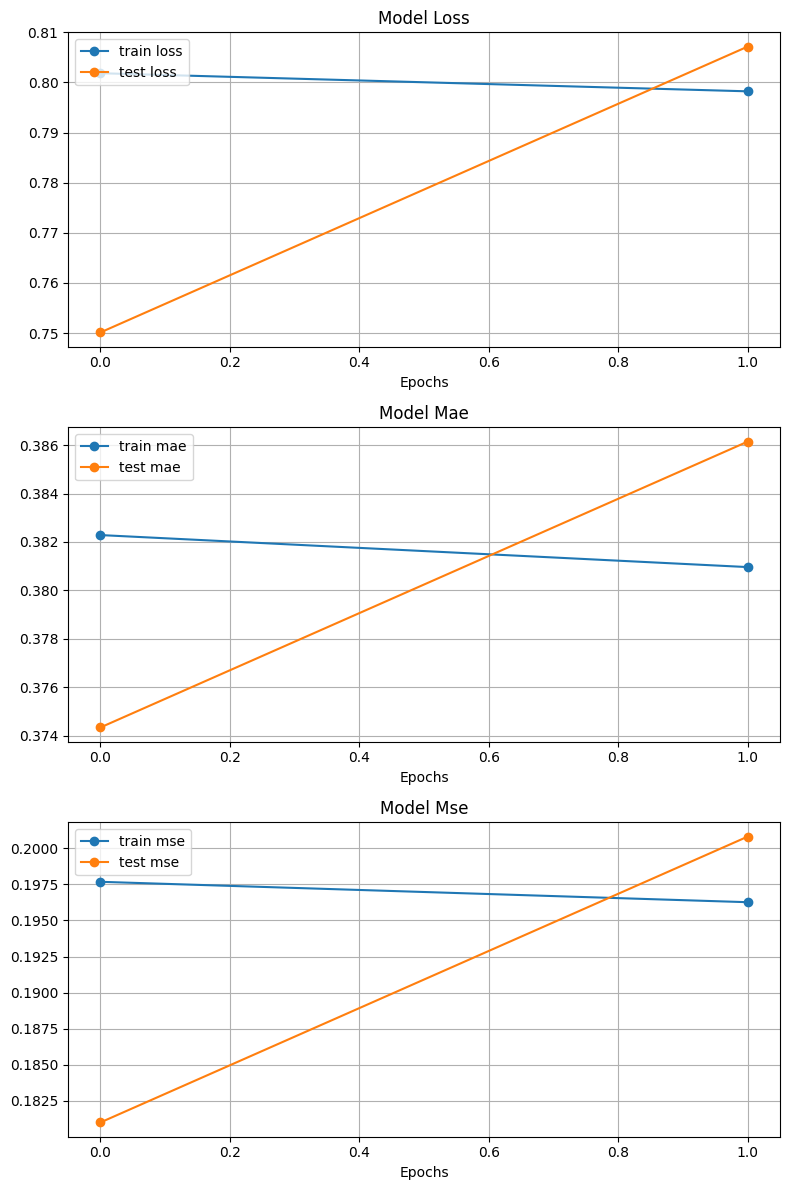

In [115]:
metrics = ["loss", "mae", "mse"]

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))
for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(history.history[metric][0:-2],marker='o', label=f"train {metric}")
    ax.plot(history.history[f"val_{metric}"][0:-2], marker='o', label=f"test {metric}")
    ax.set_title(f"Model {metric.capitalize()}")
    ax.set_xlabel("Epochs")
    ax.legend(loc="upper left")
    ax.grid(True)
    
plt.tight_layout()

plt.show()

In [116]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [117]:
anime_weights = extract_weights("anime_embedding", model)

In [118]:
user_weights = extract_weights("user_embedding", model)

#### READING ANIME.CSV

In [119]:
df = pd.read_csv(INPUT_DIR+"/anime.csv")
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [120]:
df = df.replace("Unknown", np.nan)

In [121]:
def getAnimeName(anime_id):
   try:
       name = df[df["anime_id"] == anime_id].eng_version.values[0]
       if name == np.nan:
           name = df[df["anime_id"] == anime_id].Name.values[0]
   except:
       print(f"Anime ID {anime_id} not found")
       
   return name       

In [122]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
df["eng_version"] =df.anime_id.apply(lambda x: getAnimeName(x))

In [124]:
getAnimeName(67)

'Basilisk'

In [125]:
df.sort_values(by="Score",
               inplace=True,
               ascending=False,
               kind="quicksort",
               na_position="last")

In [126]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [129]:
df = df[["anime_id", "eng_version", "Score", "Genres", "Episodes", "Type", "Premiered","Members"]]

In [130]:
df.head()

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",51,TV,Spring 2015,404121


In [138]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df.anime_id == anime]
    if isinstance(anime, str):
        return df[df.eng_version == anime]

In [140]:
getAnimeFrame(40028, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",16,TV,Winter 2021,733260


In [144]:
getAnimeFrame("Steins;Gate", df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162


#### ANIME_WITH_SYNOPSIS.CSV

In [147]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]

In [150]:
synopsis_df = pd.read_csv(INPUT_DIR+"/anime_with_synopsis.csv", usecols=cols)

In [151]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [153]:
def getSynopsis(anime, df):
    if isinstance(anime, int):
        return synopsis_df[synopsis_df.MAL_ID==anime].sypnopsis.values[0]
    if isinstance(anime, str):
        return synopsis_df[synopsis_df.Name==anime].sypnopsis.values[0]
    

In [154]:
getSynopsis(40028, df)

"Gabi Braun and Falco Grice have been training their entire lives to inherit one of the seven titans under Marley's control and aid their nation in eradicating the Eldians on Paradis. However, just as all seems well for the two cadets, their peace is suddenly shaken by the arrival of Eren Yeager and the remaining members of the Survey Corps. Having finally reached the Yeager family basement and learned about the dark history surrounding the titans, the Survey Corps has at long last found the answer they so desperately fought to uncover. With the truth now in their hands, the group set out for the world beyond the walls. In Shingeki no Kyojin: The Final Season , two utterly different worlds collide as each party pursues its own agenda in the long-awaited conclusion to Paradis' fight for freedom."

In [155]:
getSynopsis("Steins;Gate", df)

'The self-proclaimed mad scientist Rintarou Okabe rents out a room in a rickety old building in Akihabara, where he indulges himself in his hobby of inventing prospective "future gadgets" with fellow lab members: Mayuri Shiina, his air-headed childhood friend, and Hashida Itaru, a perverted hacker nicknamed "Daru." The three pass the time by tinkering with their most promising contraption yet, a machine dubbed the "Phone Microwave," which performs the strange function of morphing bananas into piles of green gel. Though miraculous in itself, the phenomenon doesn\'t provide anything concrete in Okabe\'s search for a scientific breakthrough; that is, until the lab members are spurred into action by a string of mysterious happenings before stumbling upon an unexpected success—the Phone Microwave can send emails to the past, altering the flow of history. Adapted from the critically acclaimed visual novel by 5pb. and Nitroplus, Steins;Gate takes Okabe through the depths of scientific theory 

### CONTENT / ITEM BASED RECOMMENDATION

In [164]:
pd.set_option("max_colwidth", None)

In [210]:
def find_similar_animes(name, anime_weights, anime2anime_encoded,
                        anime2anime_decoded, df, synopsis_df, n=10, return_dist=False, neg=False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]   
        encoded_index = anime2anime_encoded.get(index)
    
        weights = anime_weights
        
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)

        n=n+1
        
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
            
        print(f"Anime closest to {name}")

        
        if return_dist:
            return dists, closest
        
        SimilarityArr = []
        

        for close in closest:
            decoded_id = anime2anime_decoded.get(close)
            
            synopsis = getSynopsis(decoded_id, synopsis_df) 
            
            anime_frame = getAnimeFrame(decoded_id, df) 
            
            anime_name = anime_frame.eng_version.values[0]
            genre = anime_frame.Genres.values[0]  
            similarity = dists[close]

            SimilarityArr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity": similarity,
                "genre": genre,
                "synopsis": synopsis
            }) 
  
        Frame = pd.DataFrame(SimilarityArr).sort_values(by="similarity", ascending=False)
        return Frame[Frame.anime_id != index].drop(["anime_id"],axis=1)
        
    except Exception as e:
        print("Error occurred" , e)
    
        
        
            
            
        

In [212]:
find_similar_animes("Steins;Gate",
                    anime_weights,
                    anime2anime_encoded,
                    anime2anime_decoded, 
                    df,
                    synopsis_df,
                    n=2)

Anime closest to Steins;Gate


,name,similarity,genre,synopsis
1,NaN,0.336723,"Action, Demons",Promotional anime for Koei-Tecmo game Toukiden 2 by Studio 4°C.
0,NaN,0.323993,"Action, Adventure, Fantasy",short special that features characters from the arcade game Lord of Vermilion III engaged in battle.
